In [5]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifie
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# ----------------------------------------------- Import data --------------------------------------------

df = pd.read_csv('./resources/data.csv', index_col=0)

In [6]:
# ------------------------------------------ Remove unnecessary columns -----------------------------------

# Remove id column and use a default index
df.reset_index(drop=True, inplace=True)

df.drop(columns = [
        'member_id',
        'grade',
        'emp_title',
        'pymnt_plan',
        'desc',
        'title',
        'zip_code',
        'initial_list_status',
        'out_prncp_inv',
        'total_pymnt_inv',
        'funded_amnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'collections_12_mths_ex_med',
        'mths_since_last_major_derog',
        'policy_code',
        'application_type',
        'annual_inc_joint',
        'dti_joint',
        'verification_status_joint',
        'open_acc_6m',
        'open_il_6m',
        'open_il_12m',
        'open_il_24m',
        'mths_since_rcnt_il',
        'total_bal_il',
        'il_util',
        'open_rv_12m',
        'open_rv_24m',
        'max_bal_bc',
        'all_util',
        'inq_fi',
        'total_cu_tl',
        'inq_last_12m',
        'total_rev_hi_lim',
        'open_acc',
        'mths_since_last_record',
        'mths_since_last_delinq'
        ], inplace = True)

In [7]:
# ------------------------------------------------- Normalization ----------------------------------------

# Remove "months" in column "term"
df.term = df.term.str.split().str[0]

# Rename column "sub_grade" to "grade"
df.rename(columns={'sub_grade':'grade'}, inplace = True)

# Normalize emp_length
def normalize_emp_length(emp_length):
    if (emp_length == None or (not type(emp_length) is str)):
        return
    if (emp_length == '< 1 year'):
        return '0'
    elif (emp_length == '10+ years'):
        return '10'
    else:
        return emp_length.split()[0]

df.emp_length = df.emp_length.apply(normalize_emp_length)

df.emp_length = pd.to_numeric(df.emp_length, downcast='integer') # TODO: fix the conversion (current -> float64, desired -> int8)

# df['emp_length'] = df['emp_length'].apply(lambda x: int(x) if not np.isnan(x) else x)
# df['emp_length'] = df['emp_length'].astype(str).astype(int)

# Convert types
df.loan_amnt = df.loan_amnt.astype('uint32')
df.funded_amnt = df.funded_amnt.astype('uint32')
df.term = df.term.astype('uint8')
df.int_rate = df.int_rate.astype('float16')
df.installment = df.installment.astype('float16')
df.grade = df.grade.astype('category')

# df.emp_length = df.emp_length.astype('UInt8')

df.home_ownership = df.home_ownership.astype('category')
df.annual_inc = df.annual_inc.astype('uint32')
df.verification_status = df.verification_status.astype('category')
df.purpose = df.purpose.astype('category')
df.addr_state = df.addr_state.astype('category')
df.dti = df.dti.astype('float16')
df.delinq_2yrs = df.delinq_2yrs.astype('uint8')
df.inq_last_6mths = df.inq_last_6mths.astype('uint8')
df.pub_rec = df.pub_rec.astype('uint8')
df.revol_bal = df.revol_bal.astype('uint32')
#df.revol_util = df.revol_util.astype('float16')
df.total_acc = df.total_acc.astype('uint8')
df.out_prncp = df.out_prncp.astype('float16')
df.total_pymnt = df.total_pymnt.astype('float16')
df.recoveries = df.recoveries.astype('float16')
df.acc_now_delinq = df.acc_now_delinq.astype('category')
#df.tot_coll_amt = df.tot_coll_amt.astype('float16')
#df.tot_cur_bal = df.tot_cur_bal.astype('float16')
df.default_ind = df.default_ind.astype('bool')

df.issue_d = df.issue_d.astype('datetime64')
df.earliest_cr_line = df.earliest_cr_line.astype('datetime64')
df['since_first_cr'] = ((df['issue_d'] - df['earliest_cr_line']) / np.timedelta64(1, 'M')).astype('uint16')
df['diff_loan_funded_amnt'] = (df['loan_amnt'] - df['funded_amnt']).astype('uint16')

df.drop(columns = [
        'issue_d',
        'earliest_cr_line',
        'funded_amnt'
        ], inplace = True)

df.to_csv("newData.csv")

# Decision Tree Classifier

In [33]:
import sys
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifie
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv('./newData.csv', index_col=0)

def convertTypes(df):
    df.loan_amnt = df.loan_amnt.astype('uint32')
    df.term = df.term.astype('uint8')
    df.int_rate = df.int_rate.astype('float16')
    df.installment = df.installment.astype('float16')
    df.grade = df.grade.astype('category')
    df.home_ownership = df.home_ownership.astype('category')
    df.annual_inc = df.annual_inc.astype('uint32')
    df.verification_status = df.verification_status.astype('category')
    df.purpose = df.purpose.astype('category')
    df.addr_state = df.addr_state.astype('category')
    df.dti = df.dti.astype('float16')
    df.delinq_2yrs = df.delinq_2yrs.astype('uint8')
    df.inq_last_6mths = df.inq_last_6mths.astype('uint8')
    df.pub_rec = df.pub_rec.astype('uint8')
    df.revol_bal = df.revol_bal.astype('uint32')
    df.total_acc = df.total_acc.astype('uint8')
    df.out_prncp = df.out_prncp.astype('float16')
    df.total_pymnt = df.total_pymnt.astype('float16')
    df.recoveries = df.recoveries.astype('float16')
    df.acc_now_delinq = df.acc_now_delinq.astype('category')
    df.default_ind = df.default_ind.astype('bool')

#convertTypes(df)
#df.info()

# stratified_sample, _ = train_test_split(df, test_size=0.9, stratify=df[['default_ind']])

"""dtc = DecisionTreeClassifier()

feature_cols = ['annual_inc']
X = df[feature_cols] # Features
y = df['default_ind'].values

(training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X, y, test_size=0.25)

dtc.fit(training_inputs, training_classes)

prediction_classes = dtc.predict(testing_inputs)

# with open('credit.dot', 'w') as out_file:
#    out_file = tree.export_graphviz(dtc, out_file=out_file)
    
# tree.plot_tree(dtc)

print("Confusion matrix:\n", metrics.confusion_matrix(testing_classes, prediction_classes))
print("Accuracy:",metrics.accuracy_score(testing_classes, prediction_classes))
print("Precision:", metrics.precision_score(testing_classes, prediction_classes, average='weighted'))"""

'dtc = DecisionTreeClassifier()\n\nfeature_cols = [\'annual_inc\']\nX = df[feature_cols] # Features\ny = df[\'default_ind\'].values\n\n(training_inputs,\n     testing_inputs,\n     training_classes,\n     testing_classes) = train_test_split(X, y, test_size=0.25)\n\ndtc.fit(training_inputs, training_classes)\n\nprediction_classes = dtc.predict(testing_inputs)\n\n# with open(\'credit.dot\', \'w\') as out_file:\n#    out_file = tree.export_graphviz(dtc, out_file=out_file)\n    \n# tree.plot_tree(dtc)\n\nprint("Confusion matrix:\n", metrics.confusion_matrix(testing_classes, prediction_classes))\nprint("Accuracy:",metrics.accuracy_score(testing_classes, prediction_classes))\nprint("Precision:", metrics.precision_score(testing_classes, prediction_classes, average=\'weighted\'))'

# Undersampling
### (Same amount of rows with default_ind = 0 and default_ind = 1)

/root/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


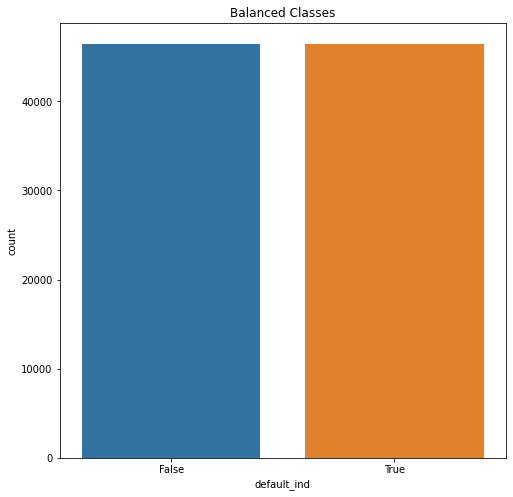

In [3]:
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 1]

# Randomly select 46467 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 0].sample(n=fraud_df['default_ind'].count(),random_state=42)

# Concatenate both dataframes again
df = pd.concat([fraud_df, non_fraud_df])

# plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sb.countplot('default_ind', data=df)
plt.title('Balanced Classes')
plt.show()

In [7]:
df.to_csv("beforeSampling.csv")
imputer = KNNImputer(n_neighbors=2)
newDf = imputer.fit_transform(df[['emp_length', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'loan_amnt','annual_inc', 'dti', 'delinq_2yrs', 'pub_rec']])

# Replace emp_length | revol_util | tot_coll_amt | loan_amnt columns with calculated values
df['emp_length'] = newDf[:,0] 
df['revol_util'] = newDf[:,1] 
df['tot_coll_amt'] = newDf[:,2] 
df['tot_cur_bal'] = newDf[:,3] 

#np.set_printoptions(threshold=sys.maxsize)
#print(newDf[:,0] )

df.emp_length = df.emp_length.astype('uint8')
df.revol_util = df.emp_length.astype('float16')
df.tot_coll_amt = df.emp_length.astype('float16')
df.tot_cur_bal = df.emp_length.astype('float16')

df.to_csv("AfterKNNImputer.csv")

In [ ]:
# Columns with missing values
df.columns[df.isnull().any()].tolist()

# Removal of Outliers (Z-Score)

In [66]:
from scipy import stats

df = pd.read_csv('./AfterKNNImputer.csv', index_col=0)

z = np.abs(stats.zscore(df.select_dtypes(exclude=['object', 'bool'])))

testDf = df.select_dtypes(exclude=['object', 'bool'])
testDf = testDf[(z < 4).all(axis=1)]
testDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77939 entries, 723757 to 233253
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_amnt              77939 non-null  int64  
 1   term                   77939 non-null  int64  
 2   int_rate               77939 non-null  float64
 3   installment            77939 non-null  float64
 4   emp_length             77939 non-null  int64  
 5   annual_inc             77939 non-null  int64  
 6   dti                    77939 non-null  float64
 7   delinq_2yrs            77939 non-null  int64  
 8   inq_last_6mths         77939 non-null  int64  
 9   pub_rec                77939 non-null  int64  
 10  revol_bal              77939 non-null  int64  
 11  revol_util             77939 non-null  float64
 12  total_acc              77939 non-null  int64  
 13  out_prncp              77939 non-null  float64
 14  total_pymnt            77939 non-null  float64
 

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# sb.stripplot(x='grade', y='annual_inc', hue='default_ind', data=df)

In [ ]:
# df.plot(subplots=True, layout=(6,6))